In [198]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [200]:
data_types = {'InsuranceCode': str}

financials_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data - financials.csv', dtype=data_types)
ins_fc_map_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data - ins-fc map.csv')
locations_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data - locations.csv')
visits_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data - visits.csv')

In [201]:
# Merge and prepare the financials data with location information
financials_locations_df = pd.merge(financials_df, locations_df[['LocationCode', 'LocationName']], on='LocationCode', how='left')
financials_locations_df['LocationNumber'] = financials_locations_df['LocationName'].str.extract('(\d+)', expand=False).fillna(0).astype(int)
financials_by_location_sorted = financials_locations_df.groupby(['LocationNumber', 'LocationCode', 'LocationName']).agg({
    'ChargesExpected': 'sum',
    'PaidToCharges': 'sum'
}).reset_index().sort_values(by='LocationNumber')

# Merge and prepare the visits data with location information
visits_locations_df = pd.merge(visits_df, locations_df[['LocationCode', 'LocationName']], on='LocationCode', how='left')
visits_locations_df['LocationNumber'] = visits_locations_df['LocationName'].str.extract('(\d+)', expand=False).fillna(0).astype(int)
visits_by_location_sorted = visits_locations_df.groupby(['LocationNumber', 'LocationCode', 'LocationName']).agg({
    'NewPatients': 'sum',
    'Visits': 'sum'
}).reset_index().sort_values(by='LocationNumber')

In [202]:
# Add a combined label for location code and name for clearer identification in plots
financials_by_location_sorted['LocationLabel'] = financials_by_location_sorted['LocationCode'] + ' - ' + financials_by_location_sorted['LocationName']
visits_by_location_sorted['LocationLabel'] = visits_by_location_sorted['LocationCode'] + ' - ' + visits_by_location_sorted['LocationName']

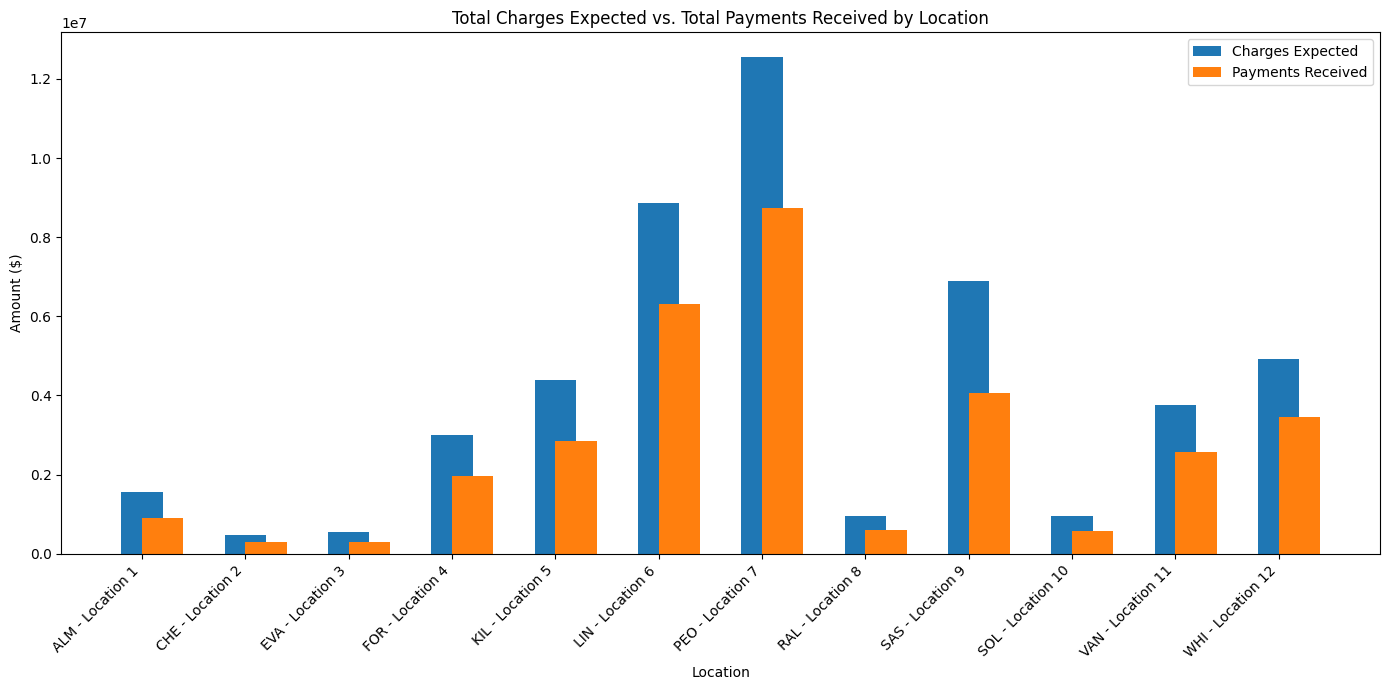

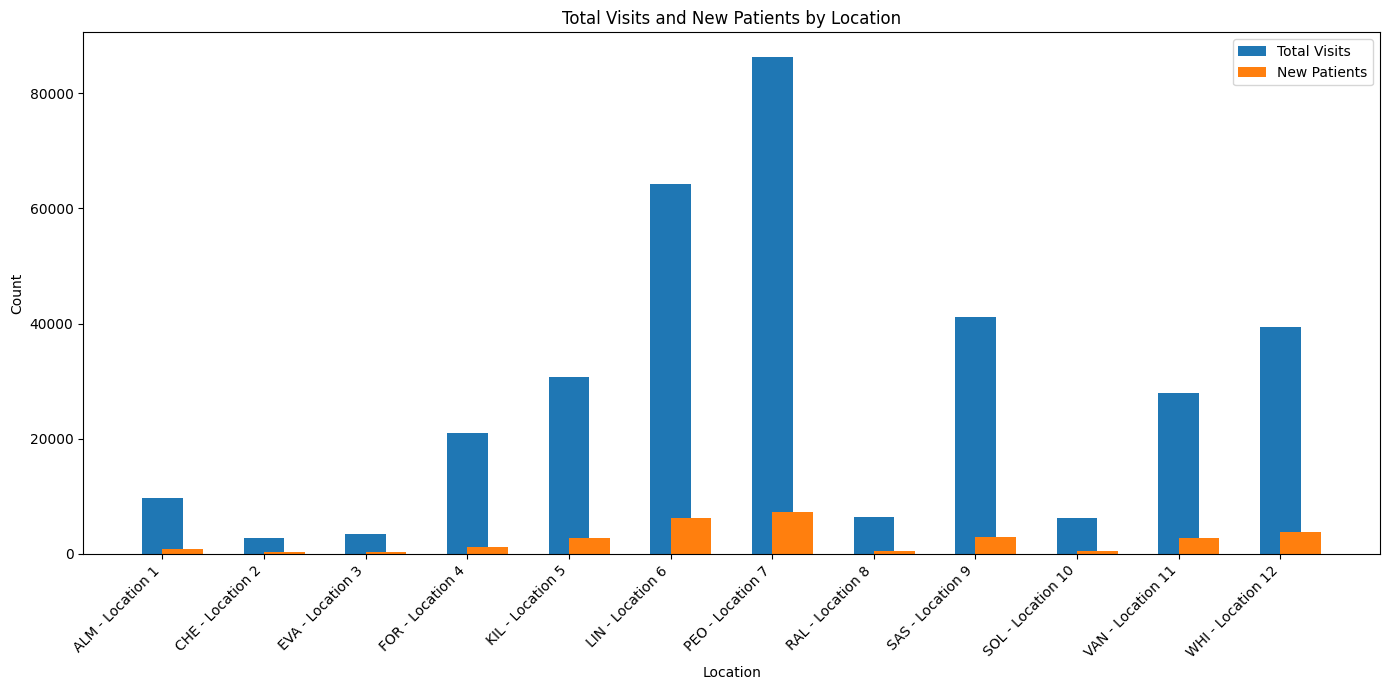

In [203]:
# Visualization 1: Total Charges Expected vs. Total Payments Received by Location
plt.figure(figsize=(14, 7))
plt.bar(financials_by_location_sorted['LocationLabel'], financials_by_location_sorted['ChargesExpected'], width=0.4, label='Charges Expected', align='center')
plt.bar(financials_by_location_sorted['LocationLabel'], financials_by_location_sorted['PaidToCharges'], width=0.4, label='Payments Received', align='edge')
plt.xlabel('Location')
plt.ylabel('Amount ($)')
plt.title('Total Charges Expected vs. Total Payments Received by Location')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Visualization 2: Total Visits and New Patients by Location
plt.figure(figsize=(14, 7))
plt.bar(visits_by_location_sorted['LocationLabel'], visits_by_location_sorted['Visits'], width=0.4, label='Total Visits', align='center')
plt.bar(visits_by_location_sorted['LocationLabel'], visits_by_location_sorted['NewPatients'], width=0.4, label='New Patients', align='edge')
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Total Visits and New Patients by Location')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

plt.show()

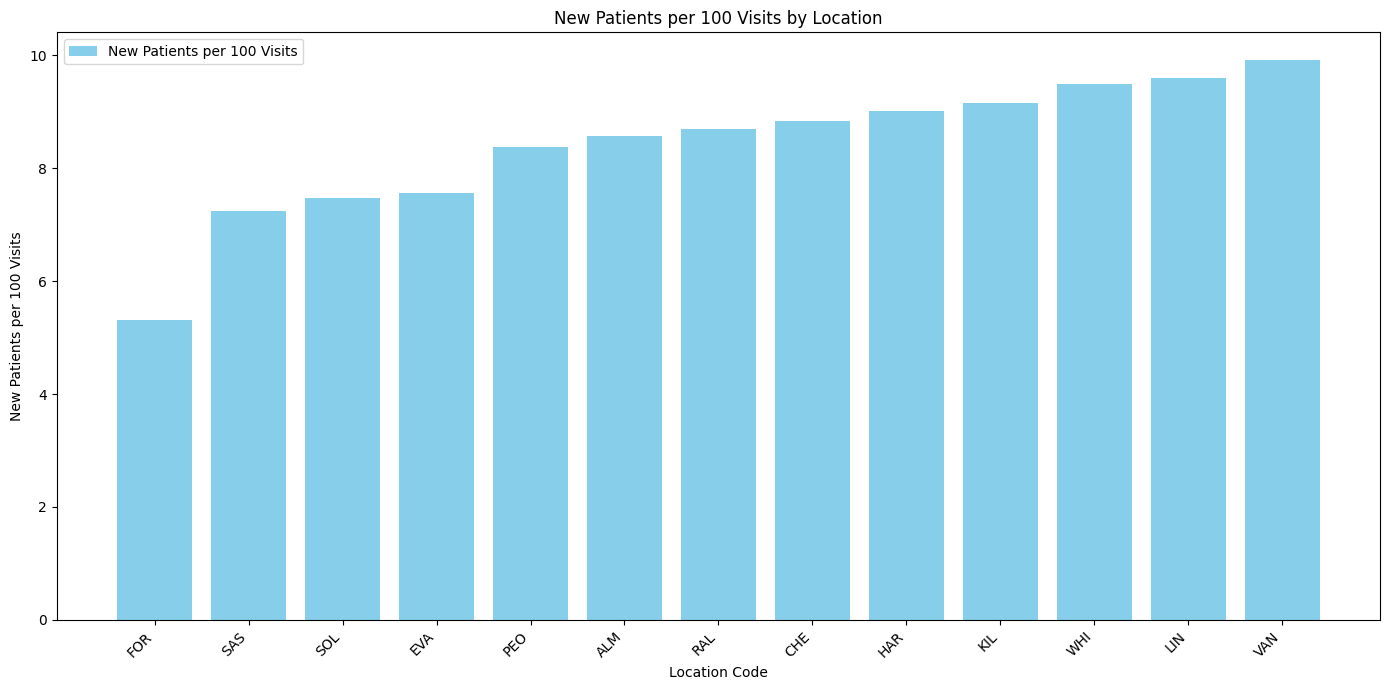

In [204]:
# Aggregate the data by LocationCode to sum NewPatients and Visits
location_summary = visits_df.groupby('LocationCode').agg(
    NewPatients=('NewPatients', 'sum'),
    Visits=('Visits', 'sum')
).reset_index()

# Calculate new patients per 100 visits for each location
location_summary['NewPatientsPer100Visits'] = (location_summary['NewPatients'] / location_summary['Visits']) * 100

# Sort the data by NewPatientsPer100Visits for visualization
location_summary_sorted = location_summary.sort_values('NewPatientsPer100Visits', ascending=True)

# Visualization: New Patients per 100 Visits by Location
plt.figure(figsize=(14, 7))
plt.bar(location_summary_sorted['LocationCode'], location_summary_sorted['NewPatientsPer100Visits'], color='skyblue', label='New Patients per 100 Visits')
plt.xlabel('Location Code')
plt.ylabel('New Patients per 100 Visits')
plt.title('New Patients per 100 Visits by Location')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

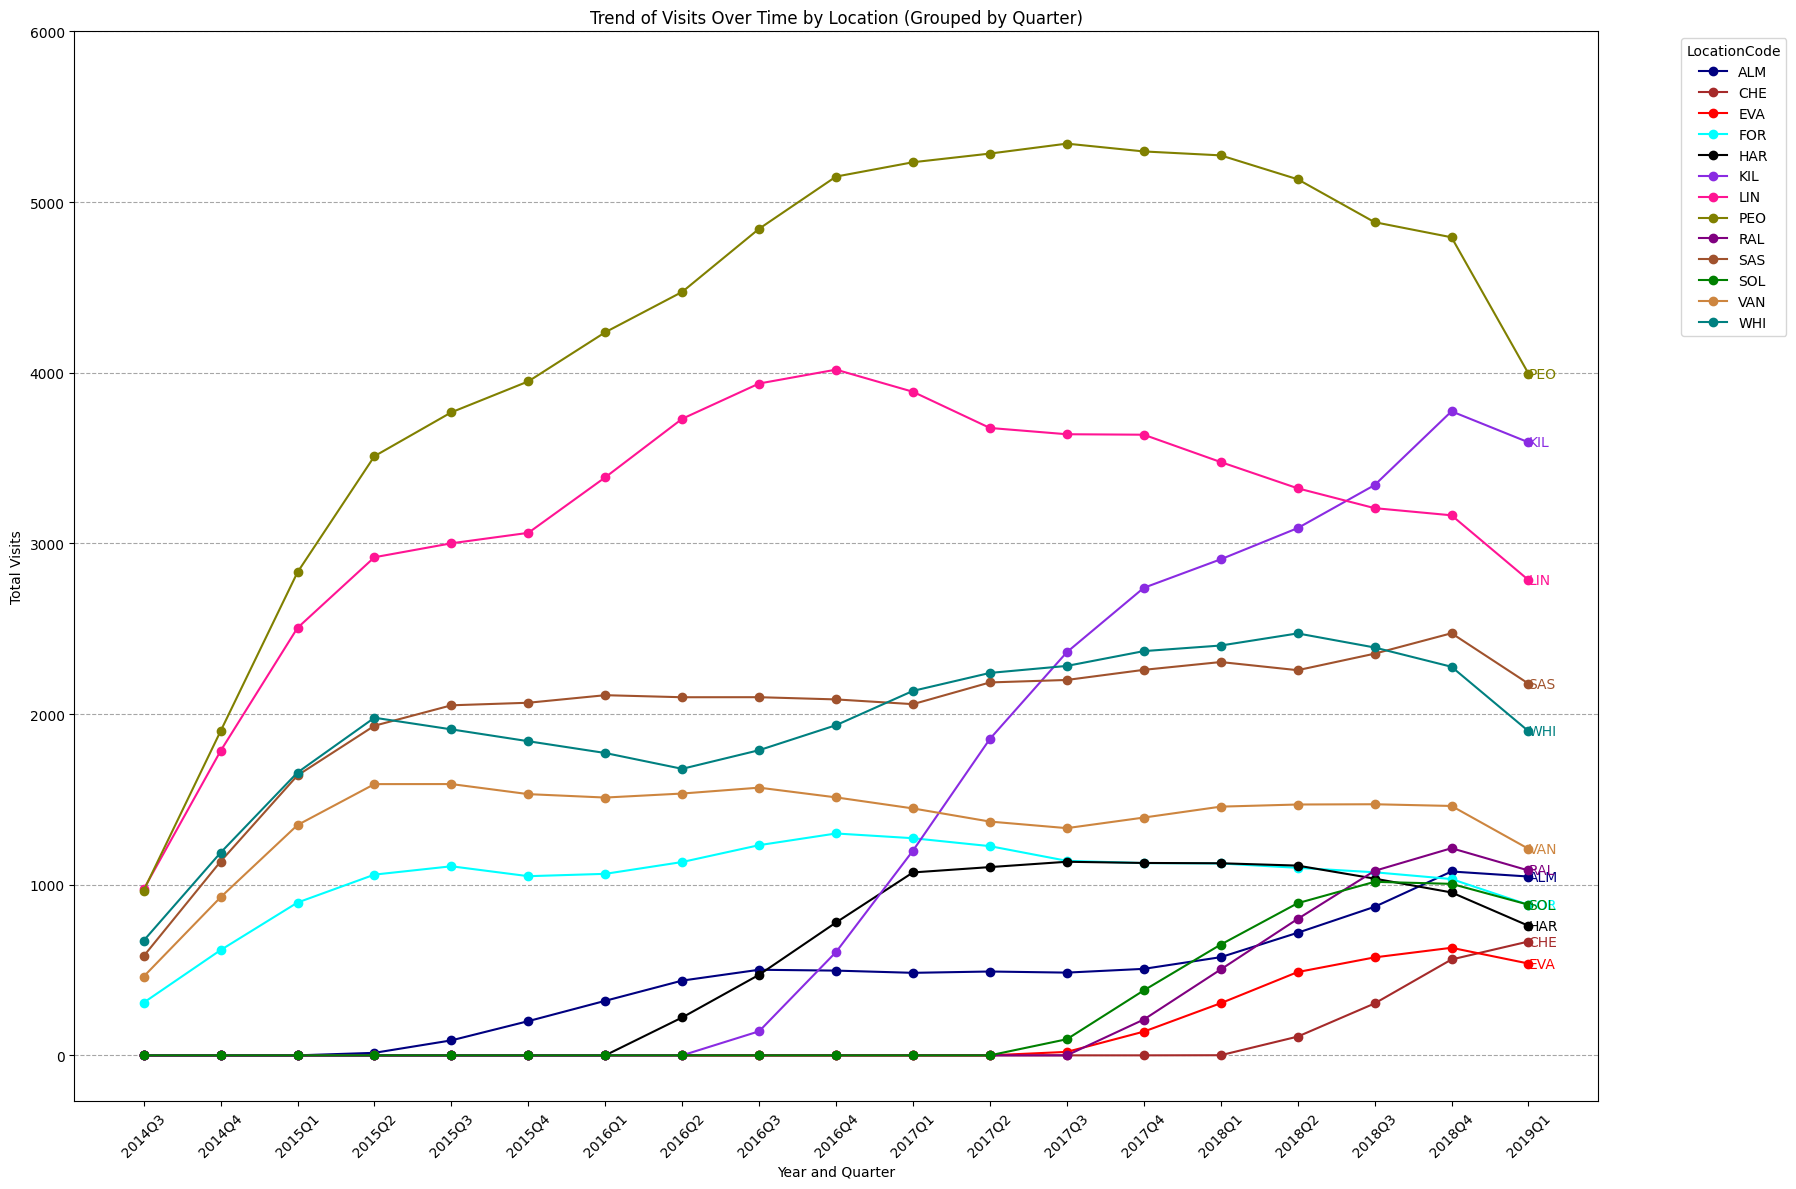

In [197]:
# Apply a rolling mean to smooth the lines
window_size = 4
visits_smoothed = visits_pivot.rolling(window=window_size).mean().dropna()

# Manually define colors for each location code
manual_colors = {
    'ALM': 'navy',
    'CHE': 'brown',
    'EVA': 'red',
    'FOR': 'cyan',
    'HAR': 'black',
    'KIL': 'blueviolet',
    'LIN': 'deeppink',
    'PEO': 'olive',
    'RAL': 'purple',
    'SAS': 'sienna',
    'SOL': 'green',
    'VAN': 'peru',
    'WHI': 'teal',
}


plt.figure(figsize=(18, 12))

# Plot each line with the manually specified color
for idx, location in enumerate(visits_smoothed.columns):
    color = manual_colors.get(location, 'black')  # Use black as default if not specified
    plt.plot(visits_smoothed.index, visits_smoothed[location], marker='o', label=location, color=color)

    # Calculate y position for annotation to avoid overlap
    y_pos = visits_smoothed[location].iloc[-1]
    plt.text(visits_smoothed.index[-1], y_pos, location, color=color, ha='left', va='center')

# Adjust y-axis to show a label for every 1000 units and add horizontal grid lines for clarity
y_max = visits_smoothed.max().max()
y_ticks = np.arange(0, y_max + 1000, 1000)
plt.yticks(y_ticks)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)  # Adding horizontal grid lines

plt.xlabel('Year and Quarter')
plt.ylabel('Total Visits')
plt.title('Trend of Visits Over Time by Location (Grouped by Quarter)')
plt.xticks(rotation=45)
plt.legend(title='LocationCode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
